In [1]:
import pandas as pd

import numpy as np
from scipy.stats import norm
import mean_confidence_interval as conf
import geometric_brownian_motion as gbm

import math
import matplotlib.pyplot as plt
%matplotlib inline 

In [4]:
class AmericanOption(object):
    '''
    Class for American Option valuation
    contract - option contract (put or call)
    S0 - initial stock value
    K - strike price
    T - time to maturity (years)
    r - annual risk free rate 
    mu - expected return
    sigma - volatility
    steps - number of steps in discretization
    reps - number of simulations 
    '''
    # Constructor
    def __init__(self,contract,S0,K,T,r,mu,sigma,steps,reps):
        self.contract = contract
        self.S0 = float(S0)
        self.K = float(K)
        self.T = float(T)
        self.r = float(r)
        self.mu = float(mu)
        self.sigma = float(sigma)
        self.steps = steps
        self.reps = reps
        self.interval = float(T/steps)
        if (contract != 'call') & (contract != 'put'):
            raise ValueError('Invalid Contract Type. Specify <call> or <put>')
        self.value = self.Sim_value()

    def Sim_value(self):
        '''
        Return European option value using Brownian Random Walk Monte-Carlo simulation
        '''
        prices = gbm.BRW(self.mu,self.sigma,self.S0,self.T,self.reps,self.steps)
        
        final_price = prices[:,-1]
        values=[]
        
        for val in final_price:
            if self.contract =='call':
                values.append(np.exp(-self.r*self.T)*np.maximum(0.0,val - self.K))
            elif self.contract =='put':
                values.append(np.exp(-self.r*self.T)*np.maximum(0.0,self.K - val))
        value, CI_95 = conf.CI(values)
#         error = np.abs(value-self.BS_value())/self.BS_value()
        return value, CI_95 #error

In [5]:
test_call = AmericanOption(contract='call',S0=100,K=105,T=1,r=0.05,mu=0.05,sigma=0.2,steps=100,reps=10000)
print ('Simulated Value:',test_call.value)

('Simulated Value:', (7.8602876734972336, 0.25458270546824585))


In [3]:
# Option parameters
S0 = 1
K = 1.1
T = 3
dt = 1
r = 0.06
n = 8

In [75]:
# Generate sample stock paths
K = 1.1
r = 0.06
paths = np.vstack([[1, 1.09, 1.08, 1.34],[1, 1.16, 1.26, 1.54],[1, 1.22, 1.07, 1.03],[1, 0.93, 0.97, 0.92],
           [1, 1.11, 1.56, 1.52],[1, 0.76, 0.77, 0.90],[1, 0.92, 0.84, 1.01],[1, 0.88, 1.22, 1.34]])
paths = pd.DataFrame(paths,columns=['t=0','t=1','t=2','t=3'],)
payout = K - paths
payout[payout < 0] = 0
paths_rev = paths.iloc[:, ::-1]
payout_rev = payout.iloc[:, ::-1]
print paths_rev
print payout_rev

    t=3   t=2   t=1  t=0
0  1.34  1.08  1.09  1.0
1  1.54  1.26  1.16  1.0
2  1.03  1.07  1.22  1.0
3  0.92  0.97  0.93  1.0
4  1.52  1.56  1.11  1.0
5  0.90  0.77  0.76  1.0
6  1.01  0.84  0.92  1.0
7  1.34  1.22  0.88  1.0
    t=3   t=2   t=1  t=0
0  0.00  0.02  0.01  0.1
1  0.00  0.00  0.00  0.1
2  0.07  0.03  0.00  0.1
3  0.18  0.13  0.17  0.1
4  0.00  0.00  0.00  0.1
5  0.20  0.33  0.34  0.1
6  0.09  0.26  0.18  0.1
7  0.00  0.00  0.22  0.1


In [37]:
pd.DataFrame(gbm.BRW(0.05,0.2,100,1,5,10))

,0,1,2,3,4,5,6,7,8,9,10
0,100.0,106.027572,97.040721,88.836367,93.053737,92.099456,84.843856,87.536896,87.150615,83.525349,93.973151
1,100.0,101.218730,94.016582,96.275418,94.354861,99.002732,92.143982,84.861576,84.994309,83.688223,86.111657
2,100.0,105.984536,104.323858,95.980667,98.034138,98.692686,97.635975,94.877955,97.075371,95.538979,93.055337
3,100.0,99.096304,93.630310,91.932341,92.687854,100.671181,90.856764,88.993796,95.827653,96.941905,97.747301
4,100.0,95.245139,93.428262,86.270793,79.777708,83.514649,85.265331,88.308349,86.596384,86.374414,87.285099


In [91]:
K = 40
r = 0.06
maturity = 1
reps = 1000
steps = 100
paths = pd.DataFrame(gbm.BRW(drift=0.06,sigma=0.2,S0=36,T=maturity,paths=reps,steps=steps))
# print paths
# payout = K - paths
payout = paths - K
payout[payout < 0] = 0
paths_rev = paths.iloc[:, ::-1]
payout_rev = payout.iloc[:, ::-1]
# print paths_rev
# print payout_rev

r = r/steps
print r

0.0006


In [93]:
for i in range(payout_rev.shape[1]-1):
    payout_1 = payout_rev.iloc[:,i]
    payout_2 = payout_rev.iloc[:,i+1]
    
    # x - prices of stocks at timestep t, if non-zero payout at time t-1
    # paths - stock prices, .iloc[:,i+1] - limit to timestep t, .iloc[payout_2.nonzero()] - limit to nonzero t-1 payoffs 
    x = paths_rev.iloc[:,i+1].iloc[payout_2.nonzero()]
    
    # y - holding value from time t-1 to t
    HV = np.exp(-r)*payout_1.iloc[payout_2.nonzero()]
    
    # Fit quadratic regression
    try:
        c,b,a = np.polyfit(x,HV,2)
    except:
        c,b,a = 0.0,0.0,0.0
    
    # Find expected holding value based on regression
    E_HV = a + b * x + c * np.square(x)
    
    # Find Exercise value at time t-1
    EV = payout_2.iloc[payout_2.nonzero()]
    
    # Note: can these for loops be combined?
    
    # overwrite payoffs at t and t-1
    # indexes of EV>E_HV
    for pos,ev in EV.iteritems():
        # if EV>E_HV, payout at t-1 is corresponding EV, and payout at t = 0
        
        if ev>E_HV[pos]:
            payout_1[pos]=0
            payout_2[pos]=EV[pos]
        # if EV<E_HV, payout (value) at t-1 is corresponding HV
        else:
            payout_2[pos]=HV[pos]
    
    # Find cases where holding is optimal, and overwrite t-1 payout with discounted t HV
    for pos,p1 in payout_1.iteritems():
        if p1>payout_2[pos]:
            payout_2[pos] = np.exp(-r)*payout_1.iloc[pos]
    
print 'Option Value: ', payout_rev.iloc[:,-1].mean()



Option Value:  2.10542320047


/Users/Jonathan/anaconda/envs/ipykernel_py2/lib/python2.7/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


In [82]:
values = payout_rev.iloc[:,-1]
value, CI_95 = conf.CI(values) 

In [84]:
value,CI_95

(4.434802526876223, 0.1743215289580535)

# Temporary cells for printing

In [29]:
temp = paths.transpose()
temp.values

array([[ 1.  ,  1.  ,  1.  ,  1.  ,  1.  ,  1.  ,  1.  ,  1.  ],
       [ 1.09,  1.16,  1.22,  0.93,  1.11,  0.76,  0.92,  0.88],
       [ 1.08,  1.26,  1.07,  0.97,  1.56,  0.77,  0.84,  1.22],
       [ 1.34,  1.54,  1.03,  0.92,  1.52,  0.9 ,  1.01,  1.34]])

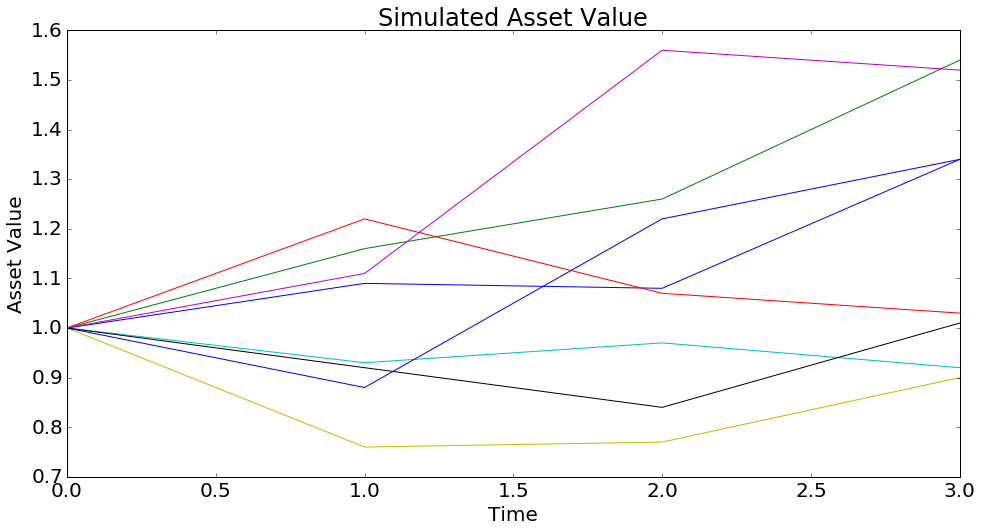

In [31]:
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline 

plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(16,8))
plt.plot(temp.values)
plt.title('Simulated Asset Value')
plt.xlabel('Time')
plt.ylabel('Asset Value')
plt.show()

In [32]:
paths_plt = np.vstack([[1, 1.09, 1.08, 1.34],[1, 1.16, 1.26, 1.54],[1, 1.22, 1.07, 1.03],[1, 0.93, 0.97, 0.92],
           [1, 1.11, 1.56, 1.52],[1, 0.76, 0.77, 0.90],[1, 0.92, 0.84, 1.01],[1, 0.88, 1.22, 1.34]])
paths_plt = pd.DataFrame(paths,columns=['t=0','t=1','t=2','t=3'],)
payout_plt = K - paths
payout_plt[payout_plt < 0] = 0
# payout_plt.drop()
payoff = payout_plt['t=3'].transpose()
payoff

0    0.00
1    0.00
2    0.07
3    0.18
4    0.00
5    0.20
6    0.09
7    0.00
Name: t=3, dtype: float64

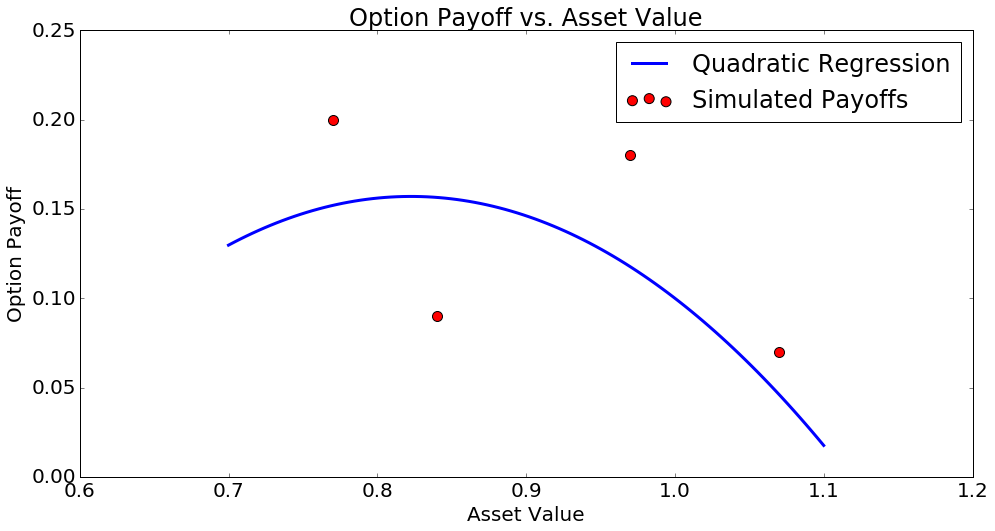

In [33]:
S_plt = [1.07, 0.97, 0.77, 0.84]
p_plt = [0.07, 0.18, 0.20, 0.09]
a=[]
b=[]

for x in np.linspace(0.7,1.1,100):
    y=-1.813*x**2+2.983*x-1.070
    a.append(x)
    b.append(y)

    
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(16,8))
plt.plot(a,b,linewidth=3)
plt.scatter(S_plt,p_plt,c='r',s=100)
plt.title('Option Payoff vs. Asset Value')
plt.xlabel('Asset Value')
plt.ylabel('Option Payoff')
plt.legend(['Quadratic Regression','Simulated Payoffs'])
plt.show()

In [34]:
np.linspace(-10,10,21)

array([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,
         1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.])

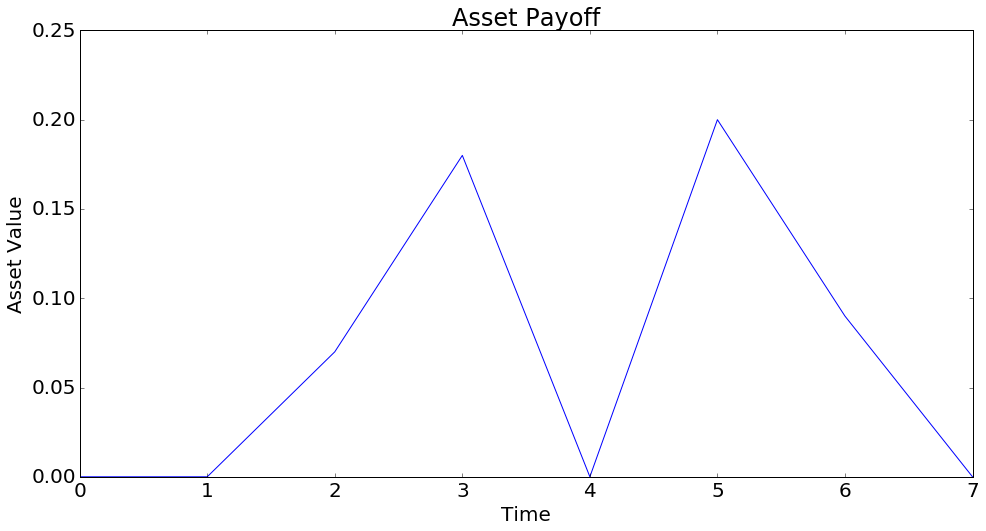

In [35]:
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(16,8))
plt.plot(payoff.values)
plt.title('Asset Payoff')
plt.xlabel('Time')
plt.ylabel('Asset Value')
plt.show()